# FASHION CAPTIONING MODEL

Dataset source:https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import random
import warnings

warnings.filterwarnings('ignore')

def sample_from_dict(d, sample=5):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))


seed = 111
tf.random.set_seed(seed)

In [ ]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 100000

# Fixed length allowed for any sequence
SEQ_LENGTH = 10

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 20
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
data = pd.read_csv('../input/hm-image-path-with-desc/article_with_paths_and_desc.csv', dtype=str)
data.rename({'article_id':'id', 'detail_desc':'desc', 'path':'path'}, inplace=True, axis=1)

In [ ]:
data.head()

,id,desc,path
0,0108775015,Jersey top with narrow shoulder straps.,../input/h-and-m-personalized-fashion-recommen...
1,0108775044,Jersey top with narrow shoulder straps.,../input/h-and-m-personalized-fashion-recommen...
2,0108775051,Jersey top with narrow shoulder straps.,../input/h-and-m-personalized-fashion-recommen...
3,0110065001,"Microfibre T-shirt bra with underwired, moulde...",../input/h-and-m-personalized-fashion-recommen...
4,0110065002,"Microfibre T-shirt bra with underwired, moulde...",../input/h-and-m-personalized-fashion-recommen...


In [ ]:
def map_list(item):
    item = "<start> " + item.strip() + " <end>"
    return [item]

data_dict = pd.Series(data.desc.map(map_list).values,index=data.path).to_dict()

In [ ]:
sample_from_dict(data_dict, 5)

{'../input/h-and-m-personalized-fashion-recommendations/images/058/0587026006.jpg': ['<start> Jumper in a soft, textured-knit cotton blend with long sleeves and ribbing around the neckline, cuffs and hem. <end>'],
 '../input/h-and-m-personalized-fashion-recommendations/images/080/0806070002.jpg': ['<start> Dress in airy chiffon with butterfly sleeves, an opening and button at the back of the neck and an elasticated seam at the waist. Jersey lining. <end>'],
 '../input/h-and-m-personalized-fashion-recommendations/images/055/0558771001.jpg': ['<start> Block-striped swim shorts with elastication and ties at the waist and a lined fly. Soft mesh inner shorts. <end>'],
 '../input/h-and-m-personalized-fashion-recommendations/images/060/0609485002.jpg': ['<start> Sports top in heavy jersey with taped details. Mesh-lined drawstring hood, short sleeves with ventilation holes under the arms, a kangaroo pocket, and slits in the sides. Longer at the back. <end>'],
 '../input/h-and-m-personalized-fa

## Preparing the dataset

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


captions_mapping, text_data = data_dict, data.desc.values

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  83756
Number of validation samples:  20940


In [ ]:
sample_from_dict(captions_mapping, 1)

{'../input/h-and-m-personalized-fashion-recommendations/images/069/0694659027.jpg': ['<start> Cap in woven fabric with a motif on the front and an adjustable plastic fastener at the back. <end>']}

In [ ]:
text_data[:5]

array(['Jersey top with narrow shoulder straps.',
       'Jersey top with narrow shoulder straps.',
       'Jersey top with narrow shoulder straps.',
       'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
       'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.'],
      dtype=object)

## Vectorizing the text data


In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


2022-07-14 12:38:00.851119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:38:00.974358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:38:00.975119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 12:38:00.977040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Building a `tf.data.Dataset` pipeline for training

We will generate pairs of images and corresponding captions using a `tf.data.Dataset` object.
The pipeline consists of two steps:

1. Read the image from the disk
2. Tokenize all the five captions corresponding to the image

In [ ]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

In [ ]:
ex = next(train_dataset.take(1).as_numpy_iterator())
ex[0].shape, ex[1].shape

((64, 299, 299, 3), (64, 1, 10))

## Building the model

Our image captioning architecture consists of three models:

1. A CNN: used to extract the image features
2. A TransformerEncoder: The extracted image features are then passed to a Transformer
                    based encoder that generates a new representation of the inputs
3. A TransformerDecoder: This model takes the encoder output and the text data
                    (sequences) as inputs and tries to learn to generate the caption.

In [ ]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=1, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]

In [ ]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation)

16719872/16705208 [==============================] - 0s 0us/step


## Model training

In [ ]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
history = caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/20


2022-07-14 12:38:21.987931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1309/1309 [==============================] - 1252s 946ms/step - loss: 6.0795 - acc: 0.1065 - val_loss: 2.8537 - val_acc: 0.4726
Epoch 2/20
1309/1309 [==============================] - 1118s 854ms/step - loss: 2.1631 - acc: 0.5205 - val_loss: 1.6837 - val_acc: 0.6196
Epoch 3/20
1309/1309 [==============================] - 1170s 894ms/step - loss: 1.6159 - acc: 0.6185 - val_loss: 1.4436 - val_acc: 0.6535
Epoch 4/20
1309/1309 [==============================] - 1175s 897ms/step - loss: 1.4430 - acc: 0.6462 - val_loss: 1.3379 - val_acc: 0.6674
Epoch 5/20
1309/1309 [==============================] - 1278s 976ms/step - loss: 1.3429 - acc: 0.6617 - val_loss: 1.2634 - val_acc: 0.6811
Epoch 6/20
1309/1309 [==============================] - 1195s 913ms/step - loss: 1.2750 - acc: 0.6750 - val_loss: 1.2222 - val_acc: 0.6869
Epoch 7/20
1309/1309 [==============================] - 1178s 900ms/step - loss: 1.2230 - acc: 0.6829 - val_loss: 1.1851 - val_acc: 0.6944
Epoch 8/20
1309/1309 [================

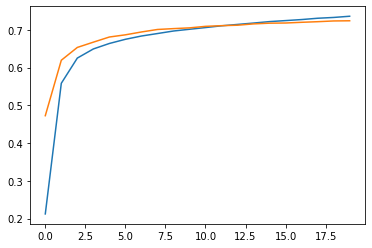

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

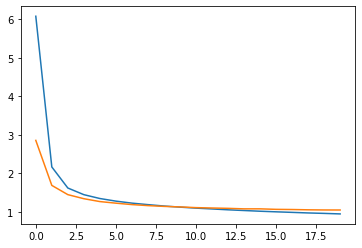

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Check sample predictions

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

def generate_caption(model):
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)
    im_toshow = plt.imread(sample_img)
    actual_caption = "Actual Caption: \n" + data.desc[data.path == sample_img].values[0]

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(im_toshow)
    plt.axis('off')
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()

    print('*******************')
    print("Predicted Caption: \n \n", decoded_caption)
    print('*******************')
    print(actual_caption)
    print('###############################################################')

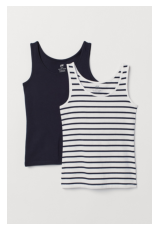

*******************
Predicted Caption: 
 
 vest tops in soft cotton jersey with a racer
*******************
Actual Caption: 
Vest tops in soft, organic cotton jersey.
###############################################################


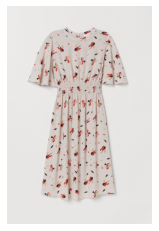

*******************
Predicted Caption: 
 
 calflength dress in a patterned cotton weave with a
*******************
Actual Caption: 
Knee-length dress in a viscose crêpe weave with a round neckline and an opening with a covered button at the back of the neck. Short, flared sleeves and a smocked seam under the bust. Unlined.
###############################################################


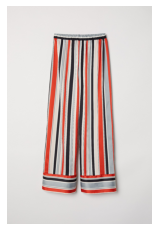

*******************
Predicted Caption: 
 
 trousers in a patterned weave with an elasticated drawstring
*******************
Actual Caption: 
Trousers in a crinkled weave with an elasticated waist and wide, straight legs with wide turn-ups at the hems.
###############################################################


In [ ]:
# Check predictions for a few samples
generate_caption(caption_model)
generate_caption(caption_model)
generate_caption(caption_model)

## Saving subclassed model

In [ ]:
caption_model.save_weights('model_weights.h5')

## Reinstantiating the model and loading saved weights

In [ ]:
loaded_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)
loaded_model.built=True
loaded_model.load_weights('./model_weights.h5')

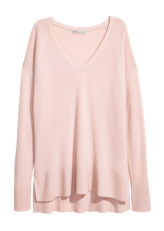

*******************
Predicted Caption: 
 
 longsleeved top in soft ribbed jersey with a vneck
*******************
Actual Caption: 
V-neck jumper in soft, fine-knit cashmere with gently dropped shoulders and long sleeves. Ribbing at the cuffs and hem and slits in the sides. Slightly longer at the back.
###############################################################


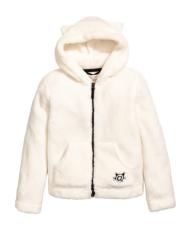

*******************
Predicted Caption: 
 
 jacket in soft pile with a hood zip down
*******************
Actual Caption: 
Jacket in soft fleece with a hood and ear appliques. Zip down the front in a contrasting colour, front pockets, and an elasticated hem with a small embroidered motif above one side.
###############################################################


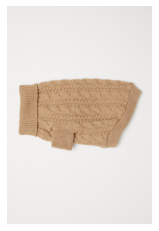

*******************
Predicted Caption: 
 
 baby exclusive puff pants in a soft textured organic
*******************
Actual Caption: 
Cable-knit dog jumper containing some wool with a foldover collar and ribbing around the front legs.
###############################################################


In [ ]:
# Check predictions for a few samples
generate_caption(loaded_model)
generate_caption(loaded_model)
generate_caption(loaded_model)